In [1]:
'''正解データ（スランプ値が20.0）の動画はIOHD0017とする'''
import Function

sec_ranges = [(48, 53), (30, 35), (45, 50), (40, 45)]
Function.ExtractFramesFromMultipleVideos(sec_ranges)

In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

try:
    # 画像の数字データを格納する配列
    x_data = []
    # 正解ラベル
    y_data = []
    # 入力データの形状
    input_shape = [256, 256, 3]
    # 学習データ画像が保存されているディレクトリパス
    image_dir = '../data/Movie'

    # "IOHD"で始まるディレクトリを探索
    for sub_dir in sorted(os.listdir(image_dir)):
        sub_dir_path = os.path.join(image_dir, sub_dir)
        if os.path.isdir(sub_dir_path) and sub_dir.startswith("IOHD"):
            # 各サブディレクトリ内のjpgファイルを読み込む
            for filename in sorted(os.listdir(sub_dir_path)):
                if filename.endswith(".jpg"):
                    img_path = os.path.join(sub_dir_path, filename)
                    img = load_img(img_path, target_size=input_shape)
                    img_array = img_to_array(img) / 255.0
                    x_data.append(img_array)
                    if sub_dir == "IOHD0017":
                        y_data.append(1)
                    else:
                        y_data.append(0)


    # 正規化
    x_data = np.array(x_data, dtype="float32")
    y_data = np.array(y_data, dtype="float32")
    
    # 確認
    print(x_data.shape)
    print(len(y_data))

except Exception as e:
    print(f"エラー発生：{e}")

2024-10-08 11:43:35.130655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 11:43:35.234568: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 11:43:35.262055: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-08 11:43:35.476834: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-08 11:43:37.033640: W tensorflow/compiler/tf2

(1198, 256, 256, 3)
1198


In [3]:
from sklearn.model_selection import train_test_split

# 学習データとテストデータ（モデルの評価に使用）に分割
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers

def make_convlayer(x_train):
    model = Sequential()

    # 第1層：畳み込み層1
    # (バッチサイズ, 32, 3, 3) -> (バッチサイズ, 32, 32, 32)
    model.add(
        Conv2D(
            filters=32,
            kernel_size=(3,3),
            input_shape=x_train[0].shape,
            padding="same",
            activation="relu"
        ))
    # 第2層：畳み込み層2
    # (バッチサイズ, 32, 32, 32) -> (バッチサイズ, 32, 32, 32)
    model.add(
        Conv2D(
            filters=32,
            kernel_size=(3,3),
            padding="same",
            activation="relu"
        ))
    # 第3層：プーリング層1
    # (バッチサイズ, 32, 32, 32) -> (バッチサイズ, 16, 16, 32)
    model.add(MaxPooling2D(pool_size=(2,2)))
    # ドロップアウト1
    model.add(Dropout(0.5))
    # 第4層：畳み込み層3
    # (バッチサイズ, 16, 16, 32) -> (バッチサイズ, 16, 16, 64)
    model.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            padding="same",
            activation="relu"
        ))
    # 第5層：畳み込み層4
    # (バッチサイズ, 16, 16, 64) -> (バッチサイズ, 16, 16, 64)
    model.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            padding="same",
            activation="relu"
        ))
    # 第6層：プーリング層2
    # (バッチサイズ, 16, 16, 64) -> (バッチサイズ, 8, 8, 64)
    model.add(MaxPooling2D(pool_size=(2,2)))
    # ドロップアウト2
    model.add(Dropout(0.5))
    # Flatten：4階テンソルから2階テンソルに変換
    # (バッチサイズ, 8, 8, 64) -> (バッチサイズ, 4096)
    model.add(Flatten())
    # 第7層：全結合層
    # (バッチサイズ, 4096) -> (バッチサイズ, 512)
    model.add(Dense(512,
                    activation="relu"))
    # ドロップアウト3
    model.add(Dropout(0.5))
    # 第8層：出力層
    # (バッチサイズ, 512) -> (バッチサイズ, 10)
    model.add(Dense(1,
                    activation="sigmoid"))
    
    # Sequentialオブジェクトのコンパイル
    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizers.Adam(0.001),
        metrics=["accuracy"]
    )

    return model

In [5]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

def train(x_train, x_test, y_train, y_test):
   # val_accuracyの改善が５エポック見られなかったら、学習率を0.5倍する
   reduce_lr = ReduceLROnPlateau(
      monitor="val_accuracy",   # 監視対象は検証データの精度
      factor=0.5,               # 学習率を減衰させる割合
      patience=5,
      verbose=1,
      mode="max",               # 最高値を監視する
      min_lr=0.0001             # 学習率の下限
   )
   
   model = make_convlayer(x_train)
   model.summary()

   callbacks_list = [reduce_lr]

   batch_size = 32
   epochs = 20

   # 学習
   history = model.fit(
      x_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      validation_split=0.2,      # 検証データの作成
      shuffle=True,              
      callbacks=callbacks_list
   )
   # テストデータでモデルを評価
   score = model.evaluate(x_test, y_test, verbose=0)
   # テストデータの損失を出力
   print(f"Test loss：{score[0]}")
   # テストデータの精度を出力
   print(f"Test accuracy：{score[1]}")

   return model, history

model, history = train(x_train, x_test, y_train, y_test)

/home/ruka/anaconda3/envs/Test3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-08 11:43:46.088757: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.
2024-10-08 11:43:46.372490: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.
2024-10-08 11:43:46.471032: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   134,218,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,284,321 (512.25 MB)

 Trainable params: 134,284,321 (512.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2024-10-08 11:43:46.856002: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 602406912 exceeds 10% of free system memory.
2024-10-08 11:43:48.104805: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.


24/24 ━━━━━━━━━━━━━━━━━━━━ 124s 5s/step - accuracy: 0.5950 - loss: 6.6437 - val_accuracy: 0.7135 - val_loss: 0.6304 - learning_rate: 0.0010
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - accuracy: 0.7632 - loss: 0.5759 - val_accuracy: 0.7135 - val_loss: 0.6159 - learning_rate: 0.0010
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 121s 5s/step - accuracy: 0.7880 - loss: 0.5560 - val_accuracy: 0.7135 - val_loss: 0.5965 - learning_rate: 0.0010
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 136s 5s/step - accuracy: 0.7634 - loss: 0.5503 - val_accuracy: 0.7135 - val_loss: 0.5928 - learning_rate: 0.0010
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 148s 5s/step - accuracy: 0.7604 - loss: 0.5585 - val_accuracy: 0.7135 - val_loss: 0.6016 - learning_rate: 0.0010
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7754 - loss: 0.5281
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
24/24 ━━━━━━━━━━━━━━━━━━━━ 136s 5s/step - accuracy: 0.7751 - loss: 0.5285 - val_accuracy: 0.7135 

In [6]:
import io

save_dir = "../output/Test_CNN_SrumpToBinaryClass/CNN1"
# ディレクトリが存在しない場合は作成
os.makedirs(save_dir, exist_ok=True)

# 出力をキャプチャするためのStringIO
buffer = io.StringIO()

# model.summary()の出力をbufferに書き込む
model.summary(print_fn=lambda x: buffer.write(x + "\n"))

# キャプチャした内容をファイルに保存
with open(os.path.join(save_dir, "model_summary.txt"), "w") as f:
    f.write(buffer.getvalue())

# StringIOのメモリを開放
buffer.close()


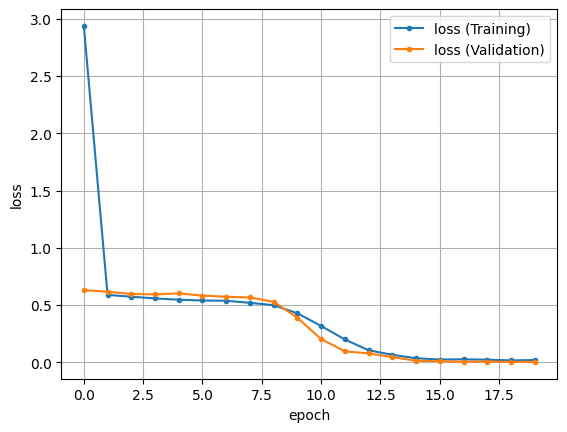

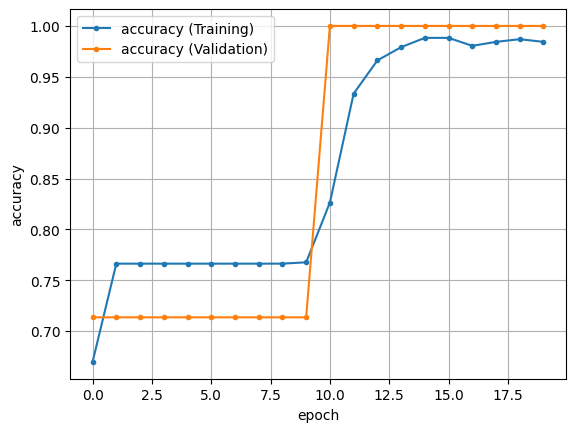

In [7]:
# 訓練データの損失をプロット
plt.plot(history.history["loss"],
         marker=".",
         label="loss (Training)")
# 検証データの損失をプロット
plt.plot(history.history["val_loss"],
         marker=".",
         label="loss (Validation)")
plt.legend()        # 凡例を表示
plt.grid()          # グリット表示
plt.xlabel("epoch") # x軸ラベル
plt.ylabel("loss")  # y軸ラベル
# 損失のグラフを保存
plt.savefig(os.path.join(save_dir, "loss.jpg"))
plt.show()

# 訓練データの精度をプロット
plt.plot(history.history["accuracy"],
         marker=".",
         label="accuracy (Training)")
# 検証データの精度をプロット
plt.plot(history.history["val_accuracy"],
         marker=".",
         label="accuracy (Validation)")
plt.legend()        # 凡例を表示
plt.grid()          # グリット表示
plt.xlabel("epoch") # x軸ラベル
plt.ylabel("accuracy")  # y軸ラベル
plt.savefig(os.path.join(save_dir, "accuracy.jpg"))
plt.show()

In [10]:
model_path = os.path.join(save_dir, "model.json")
param_path = os.path.join(save_dir, "weight.weights.h5")

# モデルをmodel.jsonとして保存
with open(model_path, "w") as json_file:
    json_file.write(model.to_json())                                # モデルをJSON形式に変換して保存
# パラメーターをweight.h5として保存
model.save_weights(param_path)     # HDF5形式で保存

In [41]:
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing import image
import os
from tensorflow.keras import optimizers
import numpy as np
import time

save_dir = "../output/Test_CNN_SrumpToBinaryClass/CNN1/17.5"
model_path = os.path.join(save_dir, "model.json")
param_path = os.path.join(save_dir, "weight.weights.h5")
# モデルの読み込み
model_r = model_from_json(open(model_path, "r").read())
# 重みの読み込み
model_r.load_weights(param_path)
# Sequentialオブジェクトのコンパイル
model_r.compile(loss="binary_crossentropy",
                optimizer=optimizers.Adam(0.001), metrics=["accuracy"])

# 処理開始時刻取得
start_time = time.perf_counter()
# 予測したい画像パス
image_path = "../data/Movie/IOHD0018/frame_2439.jpg"
# 画像のロード
img = image.load_img(image_path, target_size=(256, 256))
# 配列に変換
img_array = image.img_to_array(img)
# 次元数の追加（256, 256, 3） -> (1, 256, 256, 3)
img_array = np.expand_dims(img_array, axis=0)
# 正規化
img_array /= 255.0

# 予測開始時刻取得
prediction_start_time = time.perf_counter()
prediction = model_r.predict(img_array)
prediction_bool = prediction[0][0] > 0.5
# 予測終了時刻取得
prediction_end_time = time.perf_counter()

# 処理終了時刻取得
end_time = time.perf_counter()
# 処理時間の計算
process_time = (end_time - start_time) * 1000
prediction_time = (prediction_end_time - prediction_start_time) * 1000

print("予測結果：", prediction_bool)
print("処理時間：", process_time)
print("予測時間：", prediction_time)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
予測結果： False
処理時間： 345.4305999994176
予測時間： 335.30229999996664
